##### http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016

In [2]:
import os
import sys

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
%matplotlib inline

In [6]:
end = '2015-01-01'
start = '2007-01-01'

get_px = lambda x: web.DataReader(x, 'yahoo', start=start, end=end)['Adj Close']
symbols = ['SPY', 'TLT', 'MSFT']

data = pd.DataFrame({sym: get_px(sym) for sym in symbols})

lrets = np.log(data/data.shift(1)).dropna()

In [12]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
#     with plt.style.context(style):
    fig = plt.figure(figsize=figsize)
    #mpl.rcParams['font.family'] = 'Ubuntu Mono'
    layout = (3, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    qq_ax = plt.subplot2grid(layout, (2, 0))
    pp_ax = plt.subplot2grid(layout, (2, 1))

    y.plot(ax=ts_ax)
    ts_ax.set_title('Time Series Analysis Plots')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
    sm.qqplot(y, line='s', ax=qq_ax)
    qq_ax.set_title('QQ Plot')        
    scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

    plt.tight_layout()
    return

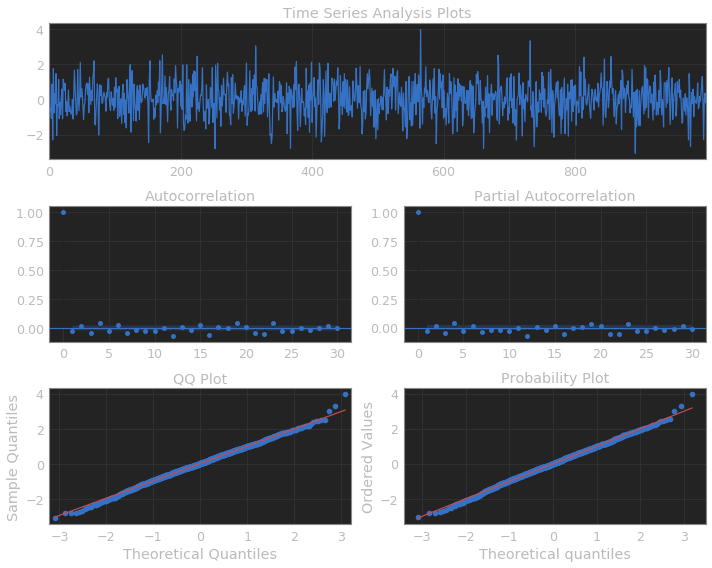

In [13]:
np.random.seed(1)

randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

In [15]:
print "Random Series\n -------------\nmean: {:.3f}\nvariance: {:.3f}\nstandard deviation: {:.3f}".format(randser.mean(), randser.var(), randser.std())

Random Series
 -------------
mean: 0.039
variance: 0.962
standard deviation: 0.981


In [17]:
ser = pd.Series(randser)

In [18]:
ser.describe()

count    1000.000000
mean        0.038812
std         0.981495
min        -3.053764
25%        -0.600160
50%         0.041293
75%         0.703999
max         3.958603
dtype: float64

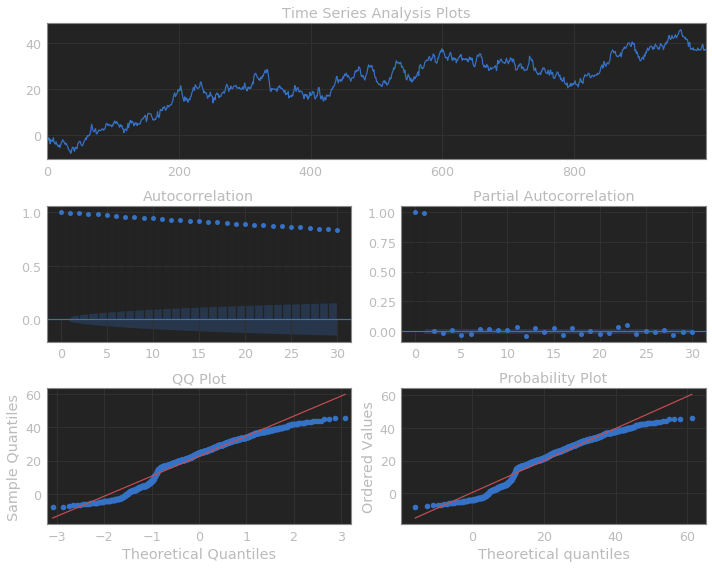

In [61]:
np.random.seed(1)
n_samples = 1000

x = np.random.normal(size=n_samples)
x[0] = x[-1]
x = np.cumsum(x)
    
tsplot(x, lags=30)

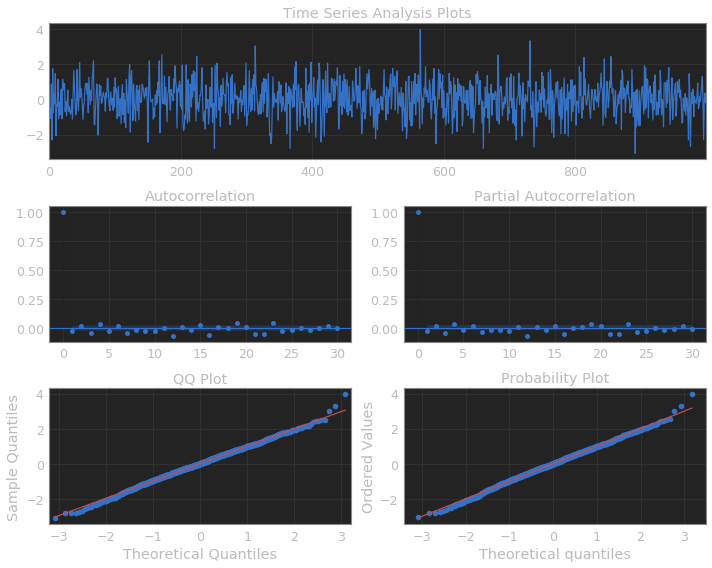

In [62]:
tsplot(np.diff(x), lags=30)

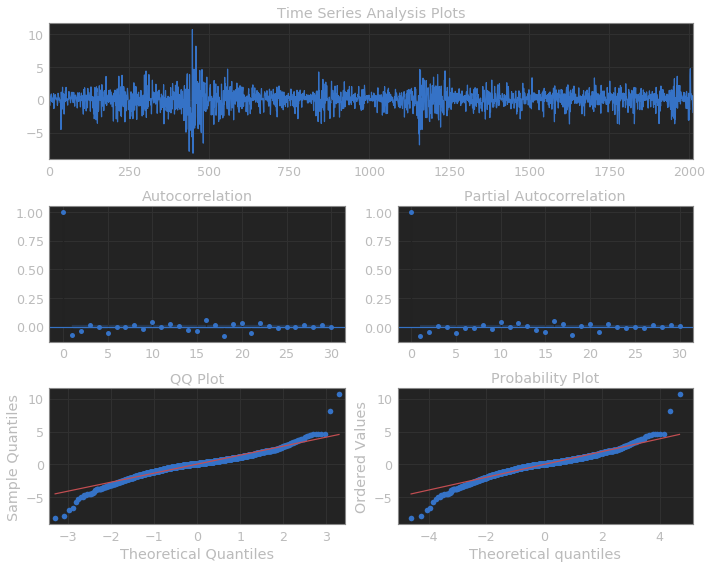

In [64]:
tsplot(np.diff(data.SPY), lags=30)

### Linear Models

Linear models aka trend models represent a TS that can be graphed using a straight line. The basic equation is:

![title](images/linear-models.png)

In this model the value of the dependent variable is determined by the beta coefficients and a singular independent variable, time. An example could be a company's sales that increase by the same amount at each time step.  Let's look at a contrived example below. In this simulation we assume Firm ABC sales regardless of time are -$50.00 (beta 0 or the intercept term) and +$25.00 (beta 1) at every time step.

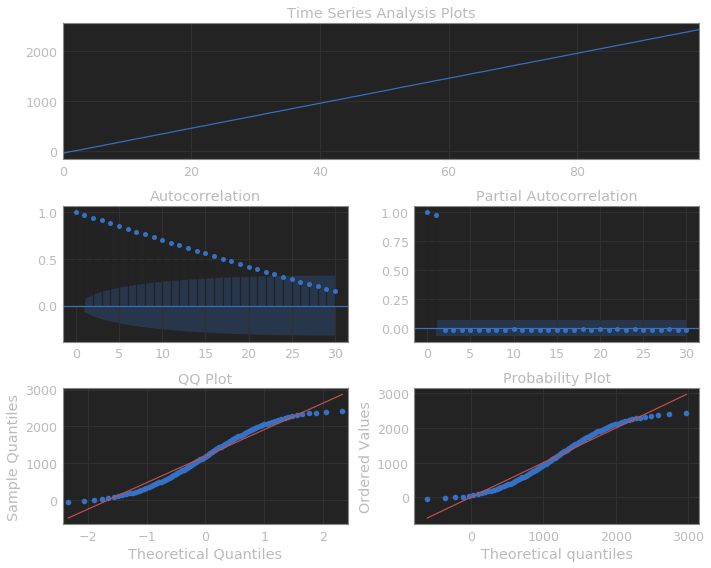

In [66]:
w = np.random.randn(100)
y = np.empty_like(w)

b0 = -50.
b1 = 25.
for t in range(len(w)):
    y[t] = b0 + b1*t + w[t]

tsplot(y, lags=30)

### Log-Linear Models


These models are similar to linear models except that the data points form an exponential function that represent a constant rate of change with respect to each time step. For example, firm ABC's sales increasing X% at each time step. When plotting the simulated sales data you get a curve that looks like this:

Text(0.5,1,u'ABC Sales')

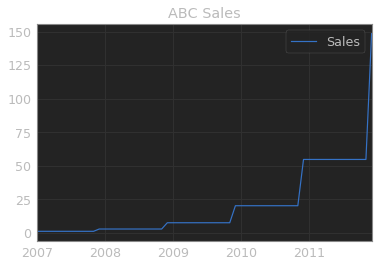

In [71]:
# Simulate ABC exponential growth

# fake dates
idx = pd.date_range('2007-01-01', '2012-01-01', freq='M')

# fake sales increasing at exponential rate
sales = [np.exp( x/12 ) for x in range(1, len(idx)+1)]

# create dataframe and plot
df = pd.DataFrame(sales, columns=['Sales'], index=idx)

# with plt.style.context('bmh'):
df.plot()
plt.title('ABC Sales')

Text(0.5,1,u'ABC Log Sales')

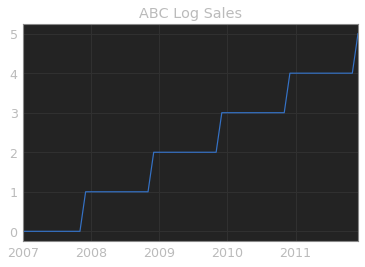

In [72]:
pd.Series(np.log(sales), index=idx).plot()
plt.title('ABC Log Sales')

### Autoregressive Models - AR(p)

When the dependent variable is regressed against one or more lagged values of itself the model is called autoregressive. The formula looks like this:

![AR(p) model formula](images/ar-p.png)

<center>`AR(p) model formula`</center>

When you describe the "order" of the model, as in, an AR model of order "p", the p represents the number of lagged variables used within the model. For example an AR(2) model or second-order autoregressive model looks like this:

![AR(2) model formula](images/ar-2.png)

<center>`AR(2) model formula`</center>

Here, alpha (a) is the coefficient, and omega (w) is a white noise term. Alpha cannot equal zero in an AR model. Note that an AR(1) model with alpha set equal to 1 is a random walk and therefore not stationary. 

![AR(1) model with alpha = 1; random walk](images/ar-1.png)

<center>`AR(1) model with alpha = 1; random walk`</center>

Let's simulate an AR(1) model with alpha set equal to 0.6

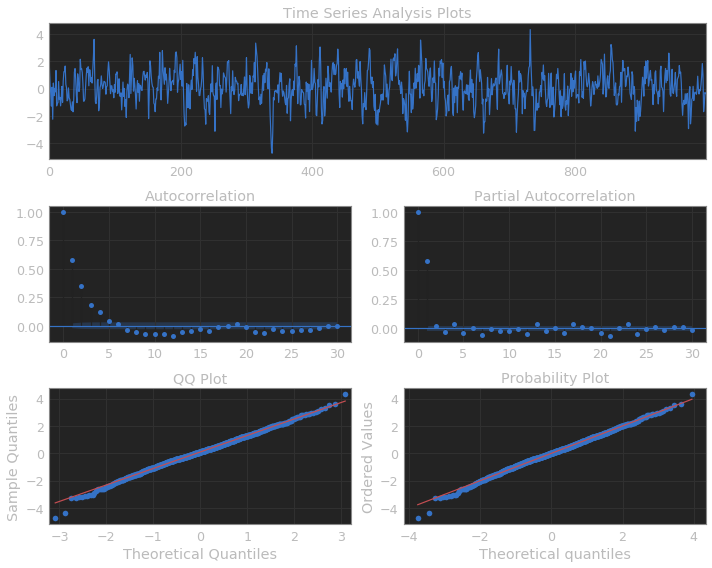

In [75]:
np.random.seed(1)
n_samples = 1000
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
# x[0] = x[-1]

    
tsplot(x, lags=30)

As expected the distribution of our simulated AR(1) model is normal. There is significant serial correlation between lagged values especially at lag 1 as evidenced by the PACF plot. 
<br><br>
Now we can fit an AR(p) model using Python's statsmodels. First we fit the AR model to our simulated data and return the estimated alpha coefficient. Then we use the statsmodels function "select_order()" to see if the fitted model will select the correct lag. If the AR model is correct the estimated alpha coefficient will be close to our true alpha of 0.6 and the selected order will equal 1.

In [80]:
# Fit an AR(p) model to simulated AR(1) model with alpha = 0.6

mdl = smt.AR(x).fit(maxlag=30, ic='aic', trend='nc')
%time est_order = smt.AR(x).select_order(maxlag=30, ic='aic', trend='nc')

true_order = 1
print('\nalpha estimate: {:3.5f} | best lag order = {}'.format(mdl.params[0], est_order))
print('\ntrue alpha = {} | true order = {}'.format(a, true_order))


CPU times: user 27.1 s, sys: 1min 37s, total: 2min 4s
Wall time: 16.9 s

alpha estimate: 0.58227 | best lag order = 1

true alpha = 0.6 | true order = 1


Looks like we were able to recover the underlying parameters of our simulated data. Let's simulate an AR(2) process with alpha_1 = 0.666 and alpha_2 = -0.333. For this we make use of statsmodel's "arma_generate_samples()" function. This function allows us to simulate an AR model of arbitrary orders. Note that there are some peculiarities of Python's version which requires us to take some extra steps before using the function.

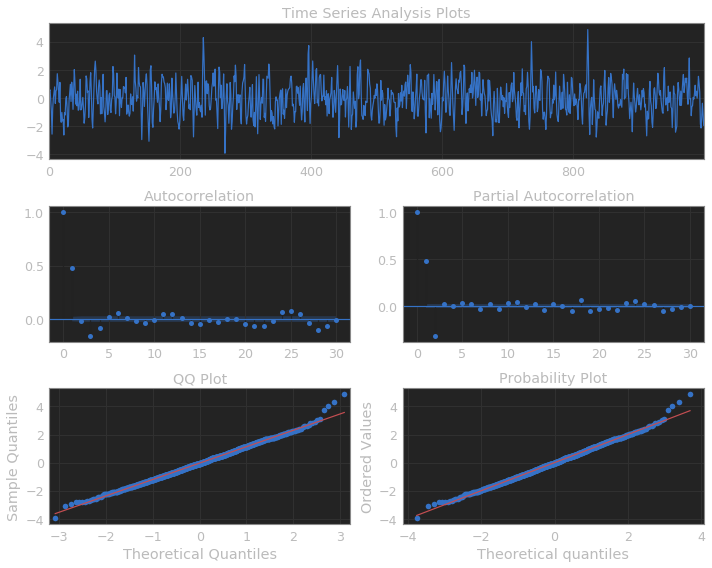

In [82]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.666, -.333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
tsplot(ar2, lags=30)

Let's see if we can recover the correct parameters.

In [83]:
# Fit an AR(p) model to simulated AR(2) process

max_lag = 10
mdl = smt.AR(ar2).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(ar2).select_order(maxlag=max_lag, ic='aic', trend='nc')

true_order = 2
print('\ncoef estimate: {:3.4f} {:3.4f} | best lag order = {}'.format(mdl.params[0],mdl.params[1], est_order))
print('\ntrue coefs = {} | true order = {}'.format([.666,-.333], true_order))
  
# coef estimate: 0.6291 -0.3196 | best lag order = 2
# true coefs = [0.666, -0.333] | true order = 2


coef estimate: 0.6291 -0.3196 | best lag order = 2

true coefs = [0.666, -0.333] | true order = 2


In [85]:
# Select best lag order for MSFT returns

max_lag = 30
mdl = smt.AR(lrets.MSFT).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(lrets.MSFT).select_order(maxlag=max_lag, ic='aic', trend='nc')

print('best estimated lag order = {}'.format(est_order))

# best estimated lag order = 23

best estimated lag order = 23


 ### Moving Average Models - MA(q)

MA(q) models are very similar to AR(p) models. The difference is that the MA(q) model is a linear combination of past white noise error terms as opposed to a linear combo of past observations like the AR(p) model. The motivation for the MA model is that we can observe "shocks" in the error process directly by fitting a model to the error terms. In an AR(p) model these shocks are observed indirectly by using the ACF on the series of past observations. The formula for an MA(q) model is:

![MA(q) model formular](images/ma-q.png)

Omega (w) is white noise with E(wt) = 0 and variance of sigma squared. Let's simulate this process using beta=0.6 and specifying the AR(p) alpha equal to 0.

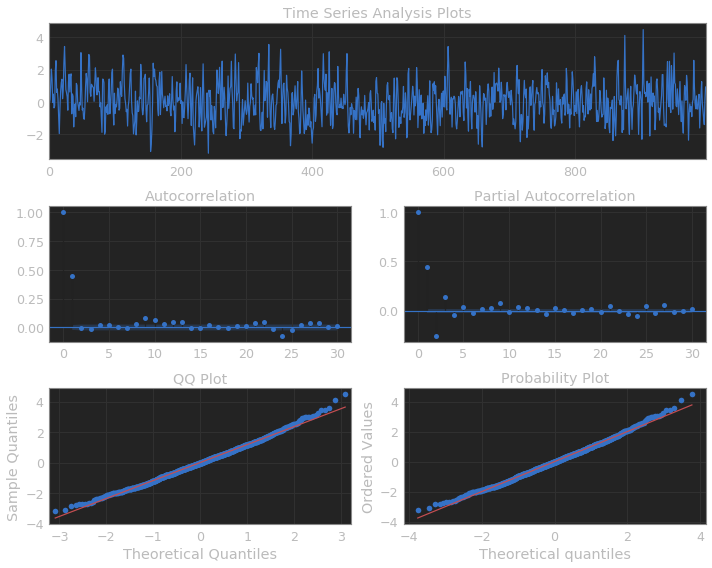

In [86]:
# Simulate an MA(1) process

n = int(1000)

# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.6])

# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
tsplot(ma1, lags=30)

The ACF function shows that lag 1 is significant which indicates that a MA(1) model may be appropriate for our simulated series. I'm not sure how to interpret the PACF showing significance at lags 2, 3, and 4 when the ACF only shows significance at lag 1. Regardless we can now attempt to fit a MA(1) model to our simulated data. We can use the same statsmodels "ARMA()" function specifying our chosen orders. We call on its "fit()" method to return the model output. 

In [87]:
# Fit the MA(1) model to our simulated time series
# Specify ARMA model with order (p, q)

max_lag = 30
mdl = smt.ARMA(ma1, order=(0, 1)).fit(
    maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1427.789
Method:                           mle   S.D. of innovations              1.009
Date:                Wed, 22 Nov 2017   AIC                           2859.578
Time:                        09:24:01   BIC                           2869.393
Sample:                             0   HQIC                          2863.308
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.5898      0.025     23.604      0.000       0.541       0.639
                                    Roots                                    
                 Real           Imaginary           M

The model was able to correctly estimate the lag coefficent as 0.58 is close to our true value of 0.6. Also notice that our 95% confidence interval does contain the true value. Let's try simulating an MA(3)  process, then use our ARMA function to fit a third order MA model to the series and see if we can recover the correct lag coefficients (betas). Betas 1-3 are equal to 0.6, 0.4, and 0.2 respectively.

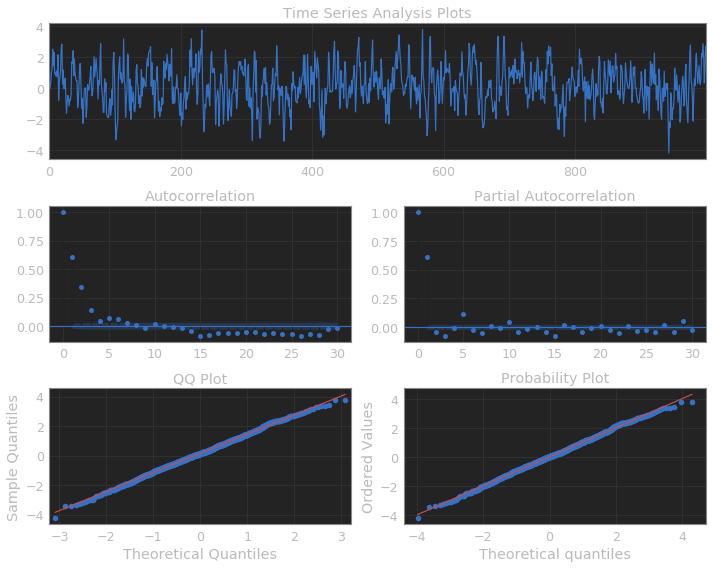

In [90]:
# Simulate MA(3) process with betas 0.6, 0.4, 0.2

n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4, 0.2])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
tsplot(ma3, lags=30)

In [91]:
# Fit MA(3) model to simulated time series

max_lag = 30
mdl = smt.ARMA(ma3, order=(0, 3)).fit(
    maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 3)   Log Likelihood               -1438.010
Method:                           mle   S.D. of innovations              1.019
Date:                Wed, 22 Nov 2017   AIC                           2884.020
Time:                        09:24:55   BIC                           2903.651
Sample:                             0   HQIC                          2891.481
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.6443      0.031     20.736      0.000       0.583       0.705
ma.L2.y        0.4364      0.036     12.182      0.000       0.366       0.507
ma.L3.y        0.2103      0.031      6.802      0.0

The model was able to estimate the real coefficients effectively. Our 95% confidence intervals also contain the true parameter values of 0.6, 0.4, and 0.3. Now let's try fitting an MA(3) model to the SPY's log returns. Keep in mind we do not know the true parameter values.

                              ARMA Model Results                              
Dep. Variable:                    SPY   No. Observations:                 2013
Model:                     ARMA(0, 3)   Log Likelihood                5756.953
Method:                           mle   S.D. of innovations              0.014
Date:                Wed, 22 Nov 2017   AIC                         -11505.906
Time:                        09:25:27   BIC                         -11483.476
Sample:                    01-04-2007   HQIC                        -11497.673
                         - 12-31-2014                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.SPY     -0.0959      0.022     -4.314      0.000      -0.139      -0.052
ma.L2.SPY     -0.0737      0.023     -3.256      0.001      -0.118      -0.029
ma.L3.SPY      0.0274      0.022      1.260      0.2

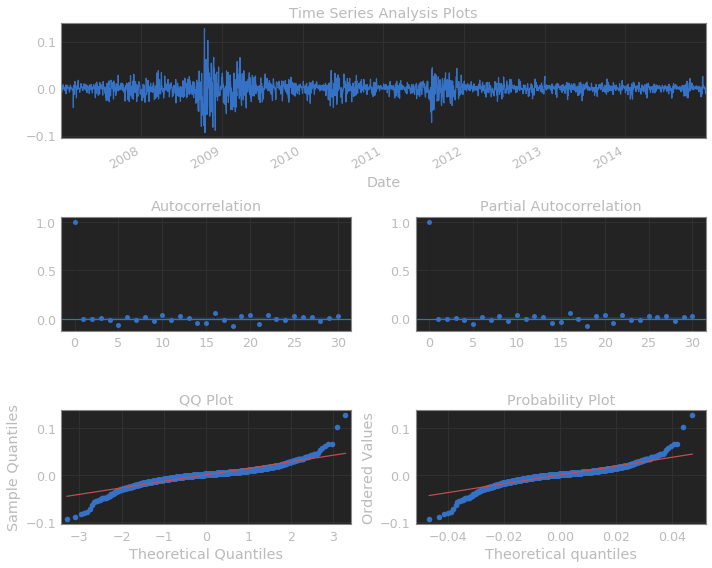

In [93]:
# Fit MA(3) to SPY returns

max_lag = 30
Y = lrets.SPY
mdl = smt.ARMA(Y, order=(0, 3)).fit(
    maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())
tsplot(mdl.resid, lags=max_lag)

Not bad. Some of the ACF lags concern me especially at 5, 16, and 18. It could be sampling error but that combined with the heaviness of the tails makes me think this isn't the best model to predict future SPY returns.

### Autoregressive Moving Average Models - ARMA(p, q)

As you may have guessed, the ARMA model is simply the merger between AR(p) and MA(q) models. Let's recap what these models represent to us from a quant finance perspective: 

  - AR(p) models try to capture (explain) the momentum and mean reversion effects often observed in trading markets. 
  - MA(q) models try to capture (explain) the shock effects observed in the white noise terms. These shock effects could be thought of as unexpected events affecting the observation process e.g. Surprise earnings, A terrorist attack, etc.

`For a set of products in a grocery store, the number of active coupon campaigns introduced at different times would constitute multiple 'shocks' that affect the prices of the products in question.`

<center>- AM207: Pavlos Protopapas, Harvard University</center>

ARMA's weakness is that it ignores the volatility clustering effects found in most financial time series. 

The model formula is:
![arma(p, q) equation](images/arma-pq.png)

<center>arma(p, q) equation</center>

Let's simulate an ARMA(2, 2) process with given parameters, then fit an ARMA(2, 2) model and see if it can correctly estimate those parameters. Set alphas equal to [0.5,-0.25] and betas equal to [0.5,-0.3]. 

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(2, 2)   Log Likelihood               -7059.362
Method:                           mle   S.D. of innovations              0.993
Date:                Wed, 22 Nov 2017   AIC                          14128.725
Time:                        09:30:01   BIC                          14161.311
Sample:                             0   HQIC                         14140.145
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.4574      0.054      8.426      0.000       0.351       0.564
ar.L2.y       -0.2409      0.015    -15.795      0.000      -0.271      -0.211
ma.L1.y        0.5236      0.055      9.487      0.0

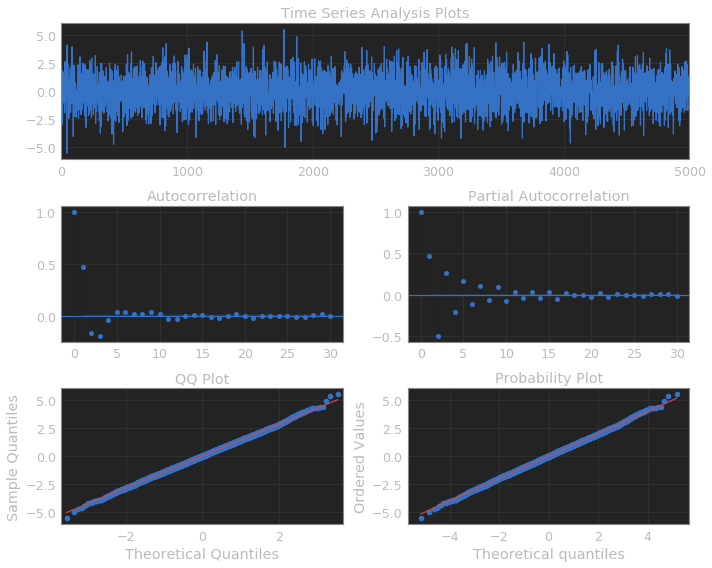

In [94]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 30

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
tsplot(arma22, lags=max_lag)

mdl = smt.ARMA(arma22, order=(2, 2)).fit(
    maxlag=max_lag, method='mle', trend='nc', burnin=burn)
print(mdl.summary())

The model has correctly recovered our parameters, and our true parameters are contained within the 95% confidence interval.

Next we simulate a ARMA(3, 2) model. After, we cycle through a non trivial number of combinations of p, q to fit an ARMA model to our simulated series. We choose the best combination based on which model produces the lowest [Akaike Information Criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion).

/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 14218.79634 | order: (3, 2)


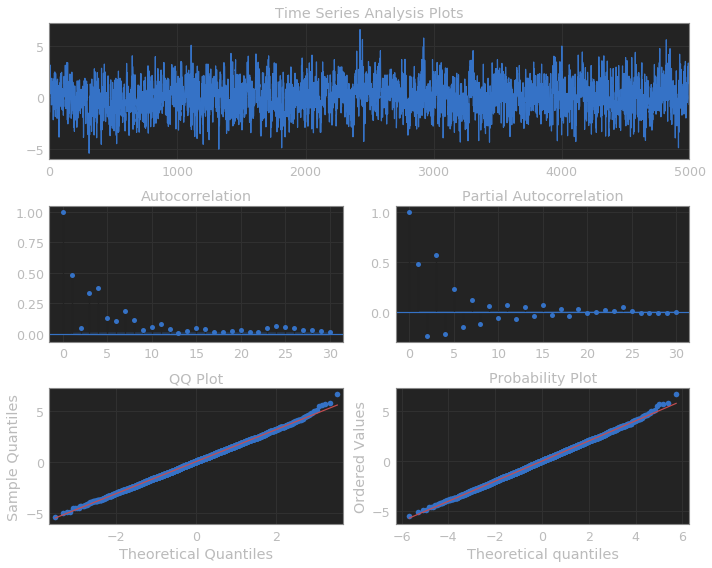

In [95]:
# Simulate an ARMA(3, 2) model with alphas=[0.5,-0.25,0.4] and betas=[0.5,-0.3]

max_lag = 30

n = int(5000)
burn = 2000

alphas = np.array([0.5, -0.25, 0.4])
betas = np.array([0.5, -0.3])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma32 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
tsplot(arma32, lags=max_lag)

# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma32, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

# aic: 14108.27213 | order: (3, 2)

We see that the correct order was selected and the model correctly estimated our parameters. However notice the MA.L1.y coefficent; the true value of 0.5 is almost outside of the 95% confidence interval!

Below we observe the model's residuals. Clearly it is a white noise process, thus the best model has been fit to explain the data.

In [97]:
# Fit ARMA model to SPY returns

best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5) # [0,1,2,3,4,5]
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(lrets['SPY'], order=(i, j)).fit(
                method='mle', trend='nc'
            )
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

# aic: -11518.22902 | order: (4, 4)

/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: -11518.75228 | order: (4, 3)


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The ACF and PACF are showing no significant autocorrelation. The QQ and Probability Plots show the residuals are approximately normal with heavy tails. However, this model's residuals do NOT look like white noise! Look at the highlighted areas of obvious conditional heteroskedasticity (conditional volatility) that the model has not captured. 

### Autoregressive Integrated Moving Average Models - ARIMA(p, d, q)


ARIMA is a natural extension to the class of ARMA models. As previously mentioned many of our TS are not stationary, however they can be made stationary by differencing. We saw an example of this when we took the first difference of a Guassian random walk and proved that it equals white noise. Said another way, we took the nonstationary random walk and transformed it to stationary white noise by first-differencing.

Without diving too deeply into the equation, just know the `"d"` references the number of times we are differencing the series. A side note, in Python we must use `np.diff()` function if we need to difference a series more than once. The `pandas` functions `DataFrame.diff()/Series.diff() only takes the first difference of a dataframe/series and does not implement the recursive differencing needed in TSA.`

In the following example, we iterate through a non-trivial number of combinations of (p, d, q) orders, to find the best ARIMA model to fit SPY returns. We use the AIC to evaluate each model. The lowest AIC wins. 

/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

aic: -11518.75228 | order: (4, 0, 3)


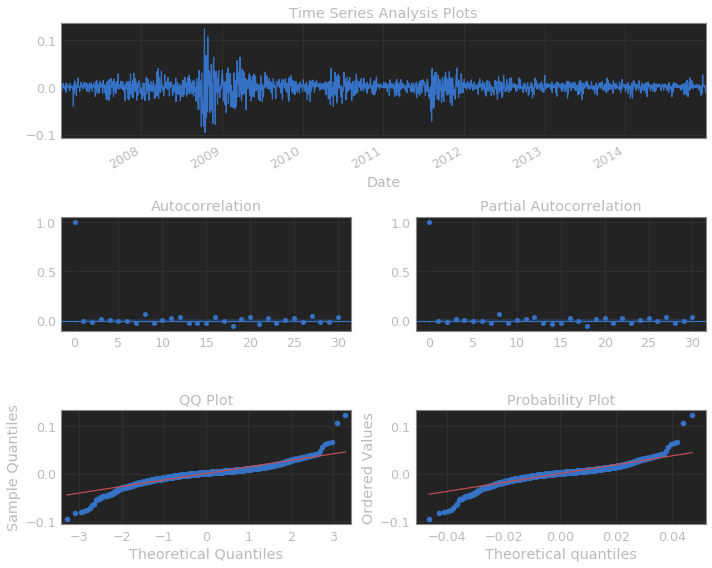

In [99]:
# Fit ARIMA(p, d, q) model to SPY Returns
# pick best order and final model based on aic

best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(lrets.SPY, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
# aic: -11518.22902 | order: (4, 0, 4)

# ARIMA model resid plot
tsplot(best_mdl.resid, lags=30)

It should be no surprise that the best model has a differencing of 0. Recall that we already took the first difference of log prices to calculate the stock returns. Below, I plot the model residuals. The result is essentially identical to the ARMA(4, 4) model we fit above. Clearly this ARIMA model has not explained the conditional volatility in the series either! 

Now we have at least accumulated enough knowledge to make a simple forecast of future returns. Here we make use of our model's `forecast()` method. As arguments, it takes an integer for the number of time steps to predict, and a decimal for the alpha argument to specify the confidence intervals. The default setting is 95% confidence. For 99% set alpha equal to 0.01. 

In [100]:
# Create a 21 day forecast of SPY returns with 95%, 99% CI
n_steps = 21

f, err95, ci95 = best_mdl.forecast(steps=n_steps) # 95% CI
_, err99, ci99 = best_mdl.forecast(steps=n_steps, alpha=0.01) # 99% CI

idx = pd.date_range(data.index[-1], periods=n_steps, freq='D')
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head()


,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
2014-12-31,0.001023,-0.025997,-0.034488,0.028043,0.036533
2015-01-01,-0.000265,-0.027392,-0.035915,0.026862,0.035386
2015-01-02,0.000223,-0.026943,-0.035479,0.027389,0.035925
2015-01-03,0.000617,-0.026549,-0.035085,0.027783,0.036319
2015-01-04,-0.000300,-0.027470,-0.036007,0.026869,0.035407


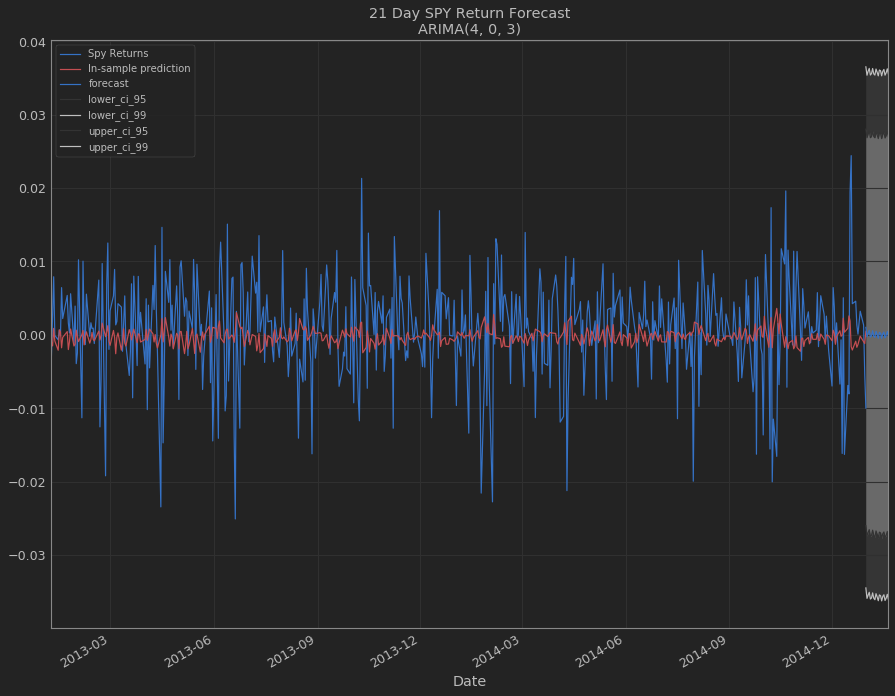

In [107]:
# Plot 21 day forecast for SPY returns

# plt.style.use('bmh')
fig = plt.figure(figsize=(15,12))
ax = plt.gca()

ts = lrets.SPY.iloc[-500:].copy()
ts.plot(ax=ax, label='Spy Returns')
# in sample prediction
pred = best_mdl.predict(ts.index[0], ts.index[-1])
pred.plot(ax=ax, style='r-', label='In-sample prediction')

styles = ['b-', '0.2', '0.75', '0.2', '0.75']
fc_all.plot(ax=ax, style=styles)
plt.fill_between(fc_all.index, fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha=0.7)
plt.fill_between(fc_all.index, fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.2)
plt.title('{} Day SPY Return Forecast\nARIMA{}'.format(n_steps, best_order))
plt.legend(loc='best', fontsize=10)

### Autoregressive Conditionally Heteroskedastic Models - ARCH(p)

ARCH(p) models can be thought of as simply an AR(p) model applied to the variance of a time series. Another way to think about it, is that the variance of our time series NOW at time t, is conditional on past observations of the variance in previous periods.
![arch(1) model formula - penn state](images/arch-1-penn-state.png)
<center>arch(1) model formula - penn state</center>
Assuming the series has zero mean we can express the model as:

![ARCH(1) model if zero mean](images/arch-1-0mean.png)
<center>ARCH(1) model if zero mean</center>


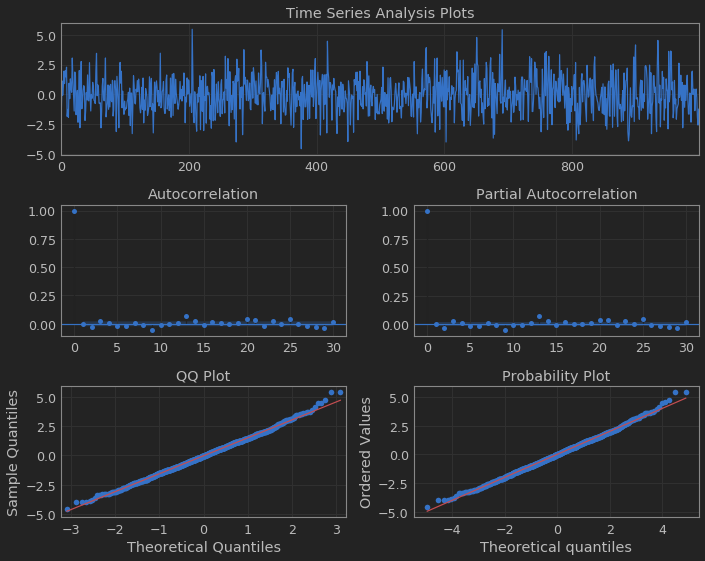

In [108]:
# Simulate ARCH(1) series
# Var(yt) = a_0 + a_1*y{t-1}**2
# if a_1 is between 0 and 1 then yt is white noise

np.random.seed(13)

a0 = 2
a1 = .5

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

for t in range(len(y)):
    Y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))

# simulated ARCH(1) series, looks like white noise
tsplot(Y, lags=30)

### Generalized Autoregressive Conditionally Heteroskedastic Models - GARCH(p,q)

Simply put GARCH(p, q)  is an ARMA model applied to the variance of a time series i.e., it has an autoregressive term and a moving average term. The AR(p) models the variance of the residuals (squared errors) or simply our time series squared. The MA(q) portion models the variance of the process. The basic GARCH(1, 1) formula is:

![garch(1, 1) formula from quantstart.com](images/garch-1-1.png)

<center>garch(1, 1) formula from quantstart.com</center>

Omega (w) is white noise, and alpha and beta are parameters of the model. Also alpha_1 + beta_1 must be less than 1 or the model is unstable. We can simulate a GARCH(1, 1) process below.

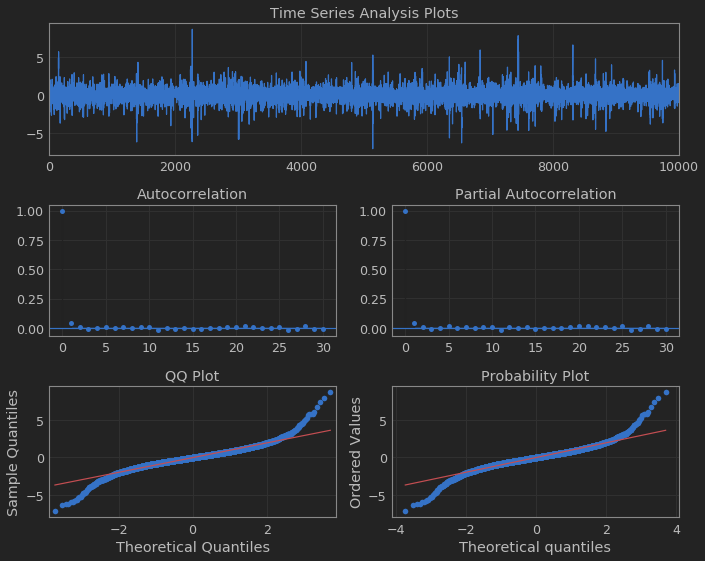

In [109]:
# Simulating a GARCH(1, 1) process

np.random.seed(2)

a0 = 0.2
a1 = 0.5
b1 = 0.3

n = 10000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

tsplot(eps, lags=30)


There is clearly autocorrelation present and the significance of the lags in both the ACF and PACF indicate we need both AR and MA components for our model. Let's see if we can recover our process parameters using a GARCH(1, 1) model. Here we make use of the `arch_model` function from the [ARCH](http://arch.readthedocs.io/en/latest/index.html) package.

In [111]:
# Fit a GARCH(1, 1) model to our simulated EPS series
# We use the arch_model function from the ARCH package

am = arch_model(eps)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     38,   Neg. LLF: 12311.7936836
Iteration:     10,   Func. Count:     71,   Neg. LLF: 12238.5926588
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12237.3032673
            Iterations: 13
            Function evaluations: 89
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -12237.3
Distribution:                  Normal   AIC:                           24482.6
Method:            Maximum Likelihood   BIC:                           24511.4
                                        No. Observations:                10000
Date:                Wed, Nov 22 2017   Df Residuals:                     9996
Time:                     

Now let's run through an example using SPY returns. The process is as follows:
  - Iterate through combinations of ARIMA(p, d, q) models to best fit our time series. 
  - Pick the GARCH model orders according to the ARIMA model with lowest AIC.
  - Fit the GARCH(p, q) model to our time series.
  - Examine the model residuals and squared residuals for autocorrelation

Also note that I've chosen a specific time period to better highlight key points. However the results will be different depending on the time period under study. 

In [114]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

# Notice I've selected a specific time period to run this analysis
TS = lrets.SPY.ix['2012':'2015']
res_tup = _get_best_model(TS)

# aic: -5255.56673 | order: (3, 0, 2)

/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

aic: -5255.56848 | order: (3, 0, 2)


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [115]:
# Now we can fit the arch model using the best fit arima model parameters

p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(TS, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

NameError: name 'order' is not defined

### References

  - Quantstart.com - [https://www.quantstart.com/articles#time-series-analysis](https://www.quantstart.com/articles#time-series-analysis)
  
  - Harvard Lectures in Python - [http://iacs-courses.seas.harvard.edu/courses/am207/blog/lecture-17.html](http://iacs-courses.seas.harvard.edu/courses/am207/blog/lecture-17.html)
  
  - Penn State Stats - [https://onlinecourses.science.psu.edu/stat510/node/78](https://onlinecourses.science.psu.edu/stat510/node/78)
  
  - stationary pic + tsplot - [http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/)
  
  - stationary quote, etc - [http://people.duke.edu/~rnau/411diff.htm](http://people.duke.edu/~rnau/411diff.htm)
  
  - interpreting qq plots - [http://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot](http://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot)
  
  - Kaplan SchweserNotes (Level 2) - Quantitative Methods